# Drug Risk Analysis

Analysis of the Drug Risk Dataset

In [1]:
reset -fs

In [2]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split,cross_val_predict, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor,AdaBoostClassifier ,RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.metrics import classification_report, r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

%matplotlib inline

In [3]:
df = pd.read_excel('Drug_Risk.xls')

In [4]:
df.columns = [c.lower() for c in df.columns]
df = df.drop(df[df.semer !='CL0'].index)

Semeron is a made up substance to test if Participants are exxagerating their consumption.
There a 8 participants that claimed to use Semeron. They can be filtered out since their other replies are not reliable either.
Notice that six of them are between 18 and 24 years old.

In [5]:
dict_age = {'-0.95197': '18-24','-0.07854': '25-34', '0.49788': '35-44','1.09449': '45-54','1.82213': '55-64',
            '2.59171': '65+'}

dict_sex = {'0.48246':'Female','-0.48246': 'Male'}

dict_edu = {'-2.43591': 'left_school','-1.7379': 'left_school','-1.43719': 'left_school_at_17_years',
           '-1.22751': 'left_school_at_18 years','-0.61113': 'Some college or university, no certificate or degree',
           '-0.05921': 'professional_certificate/ diploma', '0.45468': 'university_degree',
           '1.16365': 'masters_degree', '1.98437': 'doctorate_degree'}

dict_cou = {'-0.09765': 'Australia', '0.24923': 'Canada', '-0.46841': 'New Zealand', '-0.28519': 'Other',
            '0.21128': 'Republic of Ireland','0.96082': 'UK','-0.57009': 'USA'}

dict_eth = {'-0.50212':'Asian','-1.10702': 'Black','1.90725': 'Mixed-Black/Asian',
            '0.126': 'Mixed-White/Asian','-0.22166' :'Mixed-White/Black','0.1144': 'Other'
            ,'-0.31685': 'White'}

In [6]:
df.age = [dict_age[str(a)] for a in df.age]
df.gender = [dict_sex[str(a)]  for a in df.gender]
df.education = [dict_edu[str(a)] for a in df.education]
df.country = [dict_cou[str(a)] for a in df.country]
df.ethnicity = [dict_eth[str(a)] for a in df.ethnicity]

In [7]:
drugs = ['alcohol', 'amphet', 'amyl', 'benzos', 'caff', 'cannabis', 'choc', 'coke', 'crack',
       'ecstasy', 'heroin', 'ketamine', 'legalh', 'lsd', 'meth', 'shrooms',
       'nicotine','semer', 'vsa']

for d in drugs:
    df[d + '_user'] = [u in ('CL4', 'CL5', 'CL6') for u in df[d]]
    
drug_labels = ['Alcohol','Amphetamines', 'Amyl Nitrite', 'Benzodiazepine', 'Caffeine', 'Cannabis', 'Chocolate', 'Cocaine', 'Crack',
       'Ecstasy', 'Heroin', 'Ketamine', 'Legal Highs', 'LSD', 'Methadone', 'Magic Mushrooms',
       'Nicotine', 'Volatile Substances']


In [8]:
df[['cannabis_user', 'amphet_user']]

,cannabis_user,amphet_user
0,False,False
1,True,False
2,False,False
3,False,False
4,False,False
5,False,False
6,False,False
7,False,False
8,False,False
9,False,False


In [9]:
for d in drugs:
    df[d] = [int(c[-1:]) for c in df[d]]

Semeron is not real and used for checking if a participant exxagerates his drug habits. It can be dropped.

In [10]:
drugs.remove('semer')

In [11]:
df[['cannabis_user', 'amphet_user']]

,cannabis_user,amphet_user
0,False,False
1,True,False
2,False,False
3,False,False
4,False,False
5,False,False
6,False,False
7,False,False
8,False,False
9,False,False


## Connection between substances

When using one substace, how likely is it to use another? Which substances are used by the same person?

In [12]:
def plot_networkx_graph(G):
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size = list(map(int, nx.get_node_attributes(G, 'size').values())) , alpha = 0.5)
    nx.draw_networkx_edges(G, pos, width=0.1)
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

    plt.axis('off')
    plt.savefig('graphs/Drug_Correlations.png')
    plt.show()

In [13]:
G = nx.Graph()

G.add_nodes_from([(drug,dict(size =str(df[drug + '_user'][df[drug + '_user']].count()))) for drug in drugs])
weights = {}
for _, p in df.iterrows():
    for c, b in itertools.combinations(drugs, 2):
        weights[c + '_' + b] = sum(df[f'{c}_user'][df[f'{b}_user']])

G.add_weighted_edges_from([(key.split('_')[0], key.split('_')[1], weights[key]) for key in weights.keys()])


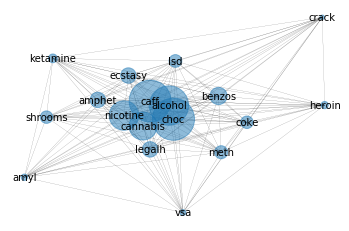

In [14]:
plot_networkx_graph(G)

Can it be improved? The weight should reflect how strongly the use of one drug correlates with the other. So what rate of the cannabis user also drink coffee and what percentage of coffee drinkers also use cannabis? Calculate the mean of that and use it as weight.

In [15]:
adjusted_weights = {}
for key in weights.keys():
    adjusted_weights[key] = weights[key]*(
        (1/df[key.split('_')[0] + '_user'][df[key.split('_')[0] + '_user']].count()) # 1/number of users of first part of key
        +(1/df[key.split('_')[1] + '_user'][df[key.split('_')[1] + '_user']].count())) # 1/number of users of second part of key
    
G.add_weighted_edges_from([(key.split('_')[0], key.split('_')[1], adjusted_weights[key]) for key in adjusted_weights.keys()])   

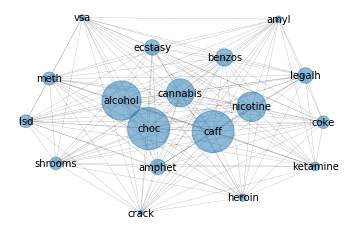

In [16]:
plot_networkx_graph(G)

In [17]:
df.cannabis_user[df['cannabis_user']].count()

781

## How does the age influence substance use?

In [18]:
for d in drugs:
    df[d + '_user'] = df[d + '_user'].astype(int)

In [19]:
df[[d + '_user' for d in drugs]]

,alcohol_user,amphet_user,amyl_user,benzos_user,caff_user,cannabis_user,choc_user,coke_user,crack_user,ecstasy_user,heroin_user,ketamine_user,legalh_user,lsd_user,meth_user,shrooms_user,nicotine_user,vsa_user
0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,1,0
2,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
6,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
7,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
9,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0


In [20]:
df.age.unique()

array(['35-44', '25-34', '18-24', '65+', '45-54', '55-64'], dtype=object)

In [21]:
sns.set()
sns.set_style('whitegrid')
#l = ['age', *(d + '_user' for d in drugs)]
ages = sorted(list(df.age.unique()))
drug_user =[d + '_user' for d in drugs]
dat = []
for age in ages:
    dat.append([sum(df[df.age == age][d]) for d in drug_user])

In [22]:
plf = pd.DataFrame(data = dat, index = ages, columns = drug_labels)

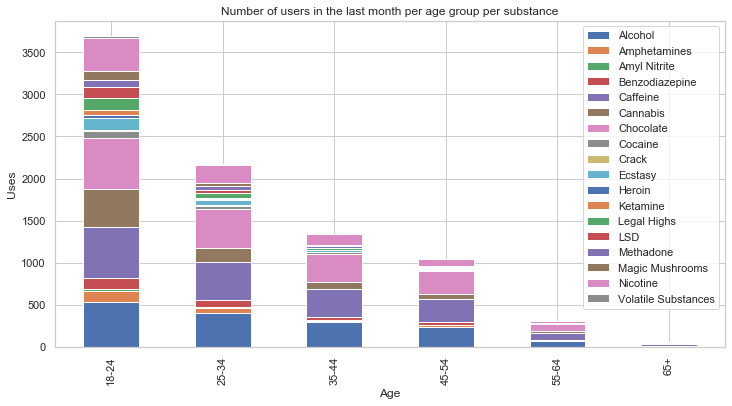

In [23]:
age_graph = plf.plot(kind = 'bar', stacked = True, figsize = (12,6))
plt.xlabel('Age')
plt.ylabel('Uses')
plt.title('Number of users in the last month per age group per substance')
plt.style.use('seaborn')
plt.savefig('graphs/uses_over_age.png')

## How many people use how many different Substances?

Redefine 'user'.

In [24]:
for d in drugs:
    df[d + '_user'] = [int(u in (3,4,5,6)) for u in df[d]]

In [25]:
diff_subs = [0] * len(drugs)
for _, row in df.iterrows():
    row['number_of_substances'] = sum([row[d] for d in drug_user])
    diff_subs[row['number_of_substances']] += 1

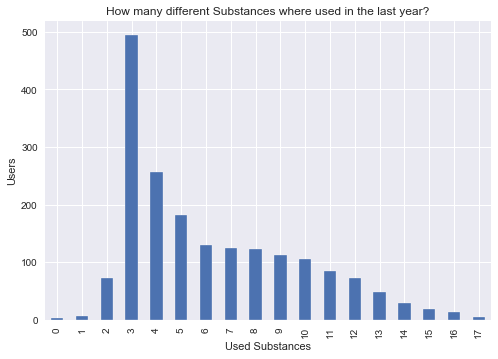

In [26]:
pd.DataFrame(enumerate(diff_subs, 0))[1].plot(kind = 'bar')
plt.xlabel('Used Substances')
plt.ylabel('Users')
plt.title('How many different Substances where used in the last year?')
plt.style.use('seaborn')
plt.savefig('graphs/substances_per_user.png')

## Other analysis

Gender

In [27]:
df.gender.value_counts()

Male      940
Female    937
Name: gender, dtype: int64

In [28]:
degrees = dict(df.education.value_counts())
degrees

{'Some college or university, no certificate or degree': 503,
 'university_degree': 478,
 'masters_degree': 283,
 'professional_certificate/ diploma': 270,
 'left_school': 126,
 'left_school_at_18 years': 99,
 'doctorate_degree': 89,
 'left_school_at_17_years': 29}

In [29]:
sorted_degree = {}
for i in [4, 7, 5, 0, 3, 1, 2, 6]:
    sorted_degree[list(degrees.keys())[i]] = list(degrees.values())[i]
sorted_degree

{'left_school': 126,
 'left_school_at_17_years': 29,
 'left_school_at_18 years': 99,
 'Some college or university, no certificate or degree': 503,
 'professional_certificate/ diploma': 270,
 'university_degree': 478,
 'masters_degree': 283,
 'doctorate_degree': 89}

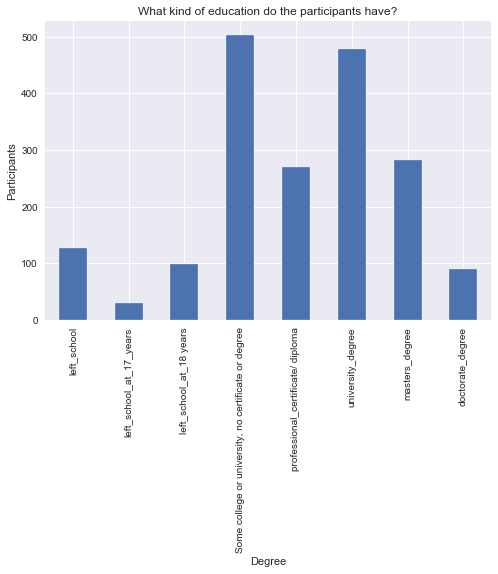

In [30]:
dfe = pd.DataFrame(sorted_degree.values(), index = sorted_degree.keys())
dfe.plot(kind = 'bar')
plt.xlabel('Degree')
plt.ylabel('Participants')
plt.title('What kind of education do the participants have?')
plt.style.use('seaborn')
plt.legend().remove()
plt.savefig('graphs/degrees.png')

# Feature Engineering

In [31]:
soft_drugs = [ 'alcohol','caff','choc', 'nicotine']
middle_drugs = [ 'amyl','cannabis', 'ecstasy', 'ketamine', 'lsd','legalh','shrooms','vsa']
hard_drugs =  ['amphet','benzos', 'coke', 'crack', 'heroin', 'meth']

In [249]:
soft_drugs_bin = [ 'alcohol_user','caff_user','choc_user', 'nicotine_user']
middle_drugs_bin = [ 'amyl_user','cannabis_user', 'ecstasy_user', 'ketamine_user', 'lsd_user','legalh_user',
                    'shrooms_user','vsa_user']
hard_drugs_bin =  ['amphet_user','benzos_user', 'coke_user', 'crack_user', 'heroin_user', 'meth_user']

In [34]:
df[cat_features]= df[cat_features].astype('category')

In [35]:
num_features = list(df.columns[df.dtypes==float])

In [211]:
age = ['18-24','25-34','35-44','45-54','55-64','65+']
gender = ['Female','Male']
education = ['left_school','left_school','left_school_at_17_years',
             'left_school_at_18 years','Some college or university, no certificate or degree',
           'professional_certificate/ diploma','university_degree','masters_degree','doctorate_degree']
country = ['Australia','Canada','New Zealand','Other','Republic of Ireland','UK','USA']
ethnicity = ['Asian','Black','Mixed-Black/Asian','Mixed-White/Asian','Mixed-White/Black','Other','White']

In [37]:
ordfeat = [age,education]
ordfeat1 = ['age','education']
for i in range(len(ordfeat)):
    encoder = OrdinalEncoder(categories=[ordfeat[i]])
    df[ordfeat1[i]] = encoder.fit_transform(df[ordfeat1[i]].values.reshape(-1, 1))

In [38]:
encoder = OneHotEncoder(dtype=np.int, sparse=True)
onehotfeat = ['gender','country','ethnicity']
nominals = pd.DataFrame(
    encoder.fit_transform(df[['gender', 'country','ethnicity']]).toarray(),
    columns=['Female', 'Male','Australia', 'Canada', 'New Zealand', 'Other_country','Republic of Ireland', 'UK','USA','Asian','Black','Mixed-Black/Asian', 'Mixed-White/Asian','Mixed-White/Black','Other_eth', 'White'])

In [39]:
df = df.join(nominals,rsuffix='L')
df.pop('semer')
df.pop('gender')
df.pop('country')
df.pop('ethnicity')
df.pop('semer_user')
df.pop('id')
df.head(2)

,age,education,nscore,escore,oscore,ascore,cscore,impulsive,ss,alcohol,...,Republic of Ireland,UK,USA,Asian,Black,Mixed-Black/Asian,Mixed-White/Asian,Mixed-White/Black,Other_eth,White
0,2.0,5.0,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,5,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,8.0,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,5,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [40]:
categorical_features = ['age','education','alcohol','amphet', 'amyl', 'benzos', 'caff','cannabis', 'choc', 'coke', 'crack', 'ecstasy',
                        'heroin', 'ketamine', 'legalh', 'lsd','meth','shrooms', 'nicotine', 'vsa',
                        'alcohol_user','amphet_user','amyl_user','benzos_user','caff_user','cannabis_user',
                        'choc_user','coke_user','crack_user','ecstasy_user','heroin_user','ketamine_user',
                        'legalh_user','lsd_user','meth_user','shrooms_user','nicotine_user','vsa_user',
                        'Female','Male','Australia','Canada','New Zealand','Other_country','Republic of Ireland','UK','USA','Asian',
                        'Black','Mixed-Black/Asian','Mixed-White/Asian','Mixed-White/Black','Other_eth','White']

In [41]:
for i in categorical_features:
    df[i]= df[i].astype('category')

In [42]:
num_features = ['nscore','escore','oscore','ascore','cscore','impulsive','ss']

In [283]:
drug_users = ['alcohol_user','amphet_user', 'amyl_user', 'benzos_user', 'caff_user', 'cannabis_user',
       'choc_user', 'coke_user', 'crack_user', 'ecstasy_user', 'heroin_user',
       'ketamine_user', 'legalh_user', 'lsd_user', 'meth_user', 'shrooms_user',
       'nicotine_user', 'vsa_user']

In [284]:
drug_users_list = {}
for i in drug_users:
    druggs = sum(df[i])
    drug_users_list.update({str(i):druggs})
    

In [286]:
imbalanced_sets_minor =['amyl_user', 'crack_user', 'heroin_user', 'ketamine_user',
                        'meth_user', 'vsa_user']
imbalanced_sets_major =['alcohol','caff_user', 'choc_user']

# Predictive modeling

## Train-test-split for every column

In [59]:
df = df.dropna(axis=0, how='any')

### Train-test-split binary

In [60]:
dfbin = pd.DataFrame(df, columns=['age', 'education', 'nscore', 'escore', 'oscore', 'ascore', 'cscore',
       'impulsive', 'ss','alcohol_user',
       'amphet_user', 'amyl_user', 'benzos_user', 'caff_user', 'cannabis_user',
       'choc_user', 'coke_user', 'crack_user', 'ecstasy_user', 'heroin_user',
       'ketamine_user', 'legalh_user', 'lsd_user', 'meth_user', 'shrooms_user',
       'nicotine_user', 'vsa_user', 'Female', 'Male', 'Australia', 'Canada',
       'New Zealand', 'Other_country', 'Republic of Ireland', 'UK', 'USA',
       'Asian', 'Black', 'Mixed-Black/Asian', 'Mixed-White/Asian',
       'Mixed-White/Black', 'Other_eth', 'White'])

In [61]:
for d in dfbin.columns:
    X = dfbin.drop(d,axis=1)
    y = dfbin[d]
    globals()["X_train_bin_" + str(d)], globals()["X_test_bin_" + str(d)], globals()["y_train_bin_" + str(d)], globals()["y_test_bin_" + str(d)] = train_test_split(X, y, test_size=0.25, random_state=2)

### Train-test-split multiclass

In [62]:
dfmult = pd.DataFrame(df, columns=['age', 'education', 'nscore', 'escore', 'oscore', 'ascore', 'cscore',
       'impulsive', 'ss', 'alcohol', 'amphet', 'amyl', 'benzos', 'caff',
       'cannabis', 'choc', 'coke', 'crack', 'ecstasy', 'heroin', 'ketamine',
       'legalh', 'lsd', 'meth', 'shrooms', 'nicotine', 'vsa', 'Female', 'Male', 'Australia', 'Canada',
       'New Zealand', 'Other_country', 'Republic of Ireland', 'UK', 'USA',
       'Asian', 'Black', 'Mixed-Black/Asian', 'Mixed-White/Asian',
       'Mixed-White/Black', 'Other_eth', 'White'])

In [63]:
for d in dfmult.columns:
    X = dfmult.drop(d,axis=1)
    y = dfmult[d]
    globals()["X_train_mult_" + str(d)], globals()["X_test_mult_" + str(d)], globals()["y_train_mult_" + str(d)], globals()["y_test_mult_" + str(d)] = train_test_split(X, y, test_size=0.25, random_state=2)

## Function for binary classification

Setting up the binary class function

In [257]:
mean_acc_bin = []

In [64]:
df = df.dropna(axis=0, how='any')

In [65]:
cat_features_bin = ['age','education','alcohol_user','amphet_user','amyl_user','benzos_user','caff_user','cannabis_user',
                        'choc_user','coke_user','crack_user','ecstasy_user','heroin_user','ketamine_user',
                        'legalh_user','lsd_user','meth_user','shrooms_user','nicotine_user','vsa_user',
                        'Female','Male','Australia','Canada','New Zealand','Other_country','Republic of Ireland','UK','USA','Asian',
                        'Black','Mixed-Black/Asian','Mixed-White/Asian','Mixed-White/Black','Other_eth','White']

In [304]:
def catclassifier(goal,classifier):
    X_train, X_test, y_train, y_test = globals()["X_train_bin_" + str(goal)],globals()["X_test_bin_" + str(goal)],globals()["y_train_bin_" + str(goal)],globals()["y_test_bin_" + str(goal)]
    if cat_features_bin.count(goal) !=0:
        cat_features_bin.remove(goal)
    model_name = classifier.__class__.__name__
    num_pipeline = Pipeline([('std_scaler', StandardScaler())])
    cat_pipeline = Pipeline([('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing'))
                             ,('1hot', OneHotEncoder(handle_unknown='ignore'))])
    preprocessor = ColumnTransformer([('num', num_pipeline, num_features),('cat', cat_pipeline, cat_features_bin)])
    pipe = Pipeline([('preprocessor', preprocessor),('params', classifier)])
    y_train_predicted = cross_val_predict(pipe, X_train, y_train, cv=5)
    model = pipe.fit(X_train, y_train)
    y_test_predicted = model.predict(X_test)
    print(model_name, goal)
    print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted)))
    print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted,average='micro')))
    print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted,average='micro')))
    print("Accuracy Model: {:.2f}".format(accuracy_score(y_test, y_test_predicted)))
    print("Recall Model: {:.2f}".format(recall_score(y_test, y_test_predicted,average='micro')))
    print("Precision Model: {:.2f}".format(precision_score(y_test, y_test_predicted,average='micro')))
    print(confusion_matrix(y_test, y_test_predicted))
    print(classification_report(y_test, y_test_predicted))
    mean_acc_bin.append([str(model_name),str(goal),accuracy_score(y_test, y_test_predicted).round(3)])
    cat_features_bin.append(goal)

Creating a setup for classification methods and features to be searched

In [251]:
list_classifier = [RandomForestClassifier(max_depth=3, min_samples_leaf=2, n_estimators=20,random_state=42,max_features=4),
                   GradientBoostingClassifier(learning_rate=0.01,max_depth=6,max_features=8,min_samples_leaf= 2,n_estimators= 500),
                   KNeighborsClassifier(leaf_size= 1,n_neighbors= 26),
                   DecisionTreeClassifier(max_depth=7,max_features=8,min_samples_leaf=0.1,min_samples_split=0.1),
                   SVC(kernel="rbf", C=1),
                   AdaBoostClassifier(learning_rate=0.5,n_estimators=100)
]
list_features = ['cannabis_user','nicotine_user','meth_user']

Searching for optimal classifier

In [305]:
for k in soft_drugs_bin:
    for i in list_classifier:
        catclassifier(k,i)
mean_acc_soft_bin = mean_acc_bin
mean_acc_bin = []

RandomForestClassifier alcohol_user
Accuracy: 0.93
Recall: 0.93
Precision: 0.93
Accuracy Model: 0.93
Recall Model: 0.93
Precision Model: 0.93
[[  0  33]
 [  0 435]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        33
           1       0.93      1.00      0.96       435

    accuracy                           0.93       468
   macro avg       0.46      0.50      0.48       468
weighted avg       0.86      0.93      0.90       468



/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GradientBoostingClassifier alcohol_user
Accuracy: 0.93
Recall: 0.93
Precision: 0.93
Accuracy Model: 0.93
Recall Model: 0.93
Precision Model: 0.93
[[  1  32]
 [  0 435]]
              precision    recall  f1-score   support

           0       1.00      0.03      0.06        33
           1       0.93      1.00      0.96       435

    accuracy                           0.93       468
   macro avg       0.97      0.52      0.51       468
weighted avg       0.94      0.93      0.90       468

KNeighborsClassifier alcohol_user
Accuracy: 0.93
Recall: 0.93
Precision: 0.93
Accuracy Model: 0.93
Recall Model: 0.93
Precision Model: 0.93
[[  0  33]
 [  0 435]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        33
           1       0.93      1.00      0.96       435

    accuracy                           0.93       468
   macro avg       0.46      0.50      0.48       468
weighted avg       0.86      0.93      0.90       468



/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DecisionTreeClassifier alcohol_user
Accuracy: 0.93
Recall: 0.93
Precision: 0.93
Accuracy Model: 0.93
Recall Model: 0.93
Precision Model: 0.93
[[  0  33]
 [  0 435]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        33
           1       0.93      1.00      0.96       435

    accuracy                           0.93       468
   macro avg       0.46      0.50      0.48       468
weighted avg       0.86      0.93      0.90       468



/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC alcohol_user
Accuracy: 0.93
Recall: 0.93
Precision: 0.93
Accuracy Model: 0.93
Recall Model: 0.93
Precision Model: 0.93
[[  0  33]
 [  0 435]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        33
           1       0.93      1.00      0.96       435

    accuracy                           0.93       468
   macro avg       0.46      0.50      0.48       468
weighted avg       0.86      0.93      0.90       468



/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AdaBoostClassifier alcohol_user
Accuracy: 0.92
Recall: 0.92
Precision: 0.92
Accuracy Model: 0.93
Recall Model: 0.93
Precision Model: 0.93
[[  0  33]
 [  1 434]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        33
           1       0.93      1.00      0.96       435

    accuracy                           0.93       468
   macro avg       0.46      0.50      0.48       468
weighted avg       0.86      0.93      0.89       468

RandomForestClassifier caff_user
Accuracy: 0.97
Recall: 0.97
Precision: 0.97
Accuracy Model: 0.96
Recall Model: 0.96
Precision Model: 0.96
[[  0  21]
 [  0 447]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.96      1.00      0.98       447

    accuracy                           0.96       468
   macro avg       0.48      0.50      0.49       468
weighted avg       0.91      0.96      0.93       468



/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GradientBoostingClassifier caff_user
Accuracy: 0.97
Recall: 0.97
Precision: 0.97
Accuracy Model: 0.96
Recall Model: 0.96
Precision Model: 0.96
[[  0  21]
 [  0 447]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.96      1.00      0.98       447

    accuracy                           0.96       468
   macro avg       0.48      0.50      0.49       468
weighted avg       0.91      0.96      0.93       468



/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KNeighborsClassifier caff_user
Accuracy: 0.97
Recall: 0.97
Precision: 0.97
Accuracy Model: 0.96
Recall Model: 0.96
Precision Model: 0.96
[[  0  21]
 [  0 447]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.96      1.00      0.98       447

    accuracy                           0.96       468
   macro avg       0.48      0.50      0.49       468
weighted avg       0.91      0.96      0.93       468



/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DecisionTreeClassifier caff_user
Accuracy: 0.97
Recall: 0.97
Precision: 0.97
Accuracy Model: 0.96
Recall Model: 0.96
Precision Model: 0.96
[[  0  21]
 [  0 447]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.96      1.00      0.98       447

    accuracy                           0.96       468
   macro avg       0.48      0.50      0.49       468
weighted avg       0.91      0.96      0.93       468



/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC caff_user
Accuracy: 0.97
Recall: 0.97
Precision: 0.97
Accuracy Model: 0.96
Recall Model: 0.96
Precision Model: 0.96
[[  0  21]
 [  0 447]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.96      1.00      0.98       447

    accuracy                           0.96       468
   macro avg       0.48      0.50      0.49       468
weighted avg       0.91      0.96      0.93       468



/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AdaBoostClassifier caff_user
Accuracy: 0.97
Recall: 0.97
Precision: 0.97
Accuracy Model: 0.95
Recall Model: 0.95
Precision Model: 0.95
[[  0  21]
 [  1 446]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.96      1.00      0.98       447

    accuracy                           0.95       468
   macro avg       0.48      0.50      0.49       468
weighted avg       0.91      0.95      0.93       468

RandomForestClassifier choc_user
Accuracy: 0.98
Recall: 0.98
Precision: 0.98
Accuracy Model: 0.97
Recall Model: 0.97
Precision Model: 0.97
[[  0  13]
 [  0 455]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.97      1.00      0.99       455

    accuracy                           0.97       468
   macro avg       0.49      0.50      0.49       468
weighted avg       0.95      0.97      0.96       468



/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GradientBoostingClassifier choc_user
Accuracy: 0.98
Recall: 0.98
Precision: 0.98
Accuracy Model: 0.97
Recall Model: 0.97
Precision Model: 0.97
[[  0  13]
 [  0 455]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.97      1.00      0.99       455

    accuracy                           0.97       468
   macro avg       0.49      0.50      0.49       468
weighted avg       0.95      0.97      0.96       468



/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KNeighborsClassifier choc_user
Accuracy: 0.98
Recall: 0.98
Precision: 0.98
Accuracy Model: 0.97
Recall Model: 0.97
Precision Model: 0.97
[[  0  13]
 [  0 455]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.97      1.00      0.99       455

    accuracy                           0.97       468
   macro avg       0.49      0.50      0.49       468
weighted avg       0.95      0.97      0.96       468



/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DecisionTreeClassifier choc_user
Accuracy: 0.98
Recall: 0.98
Precision: 0.98
Accuracy Model: 0.97
Recall Model: 0.97
Precision Model: 0.97
[[  0  13]
 [  0 455]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.97      1.00      0.99       455

    accuracy                           0.97       468
   macro avg       0.49      0.50      0.49       468
weighted avg       0.95      0.97      0.96       468



/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC choc_user
Accuracy: 0.98
Recall: 0.98
Precision: 0.98
Accuracy Model: 0.97
Recall Model: 0.97
Precision Model: 0.97
[[  0  13]
 [  0 455]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.97      1.00      0.99       455

    accuracy                           0.97       468
   macro avg       0.49      0.50      0.49       468
weighted avg       0.95      0.97      0.96       468



/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AdaBoostClassifier choc_user
Accuracy: 0.98
Recall: 0.98
Precision: 0.98
Accuracy Model: 0.97
Recall Model: 0.97
Precision Model: 0.97
[[  0  13]
 [  1 454]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.97      1.00      0.98       455

    accuracy                           0.97       468
   macro avg       0.49      0.50      0.49       468
weighted avg       0.95      0.97      0.96       468

RandomForestClassifier nicotine_user
Accuracy: 0.74
Recall: 0.74
Precision: 0.74
Accuracy Model: 0.74
Recall Model: 0.74
Precision Model: 0.74
[[164  52]
 [ 72 180]]
              precision    recall  f1-score   support

           0       0.69      0.76      0.73       216
           1       0.78      0.71      0.74       252

    accuracy                           0.74       468
   macro avg       0.74      0.74      0.73       468
weighted avg       0.74      0.74      0.74       468

GradientBoostingClassi

In [307]:
for k in middle_drugs_bin:
    for i in list_classifier:
        catclassifier(k,i)
mean_acc_mid_bin = mean_acc_bin
mean_acc_bin = []

RandomForestClassifier amyl_user
Accuracy: 0.93
Recall: 0.93
Precision: 0.93
Accuracy Model: 0.93
Recall Model: 0.93
Precision Model: 0.93
[[437   0]
 [ 31   0]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.97       437
           1       0.00      0.00      0.00        31

    accuracy                           0.93       468
   macro avg       0.47      0.50      0.48       468
weighted avg       0.87      0.93      0.90       468



/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GradientBoostingClassifier amyl_user
Accuracy: 0.93
Recall: 0.93
Precision: 0.93
Accuracy Model: 0.93
Recall Model: 0.93
Precision Model: 0.93
[[436   1]
 [ 30   1]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       437
           1       0.50      0.03      0.06        31

    accuracy                           0.93       468
   macro avg       0.72      0.51      0.51       468
weighted avg       0.91      0.93      0.91       468

KNeighborsClassifier amyl_user
Accuracy: 0.93
Recall: 0.93
Precision: 0.93
Accuracy Model: 0.93
Recall Model: 0.93
Precision Model: 0.93
[[437   0]
 [ 31   0]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.97       437
           1       0.00      0.00      0.00        31

    accuracy                           0.93       468
   macro avg       0.47      0.50      0.48       468
weighted avg       0.87      0.93      0.90       468



/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DecisionTreeClassifier amyl_user
Accuracy: 0.93
Recall: 0.93
Precision: 0.93
Accuracy Model: 0.93
Recall Model: 0.93
Precision Model: 0.93
[[437   0]
 [ 31   0]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.97       437
           1       0.00      0.00      0.00        31

    accuracy                           0.93       468
   macro avg       0.47      0.50      0.48       468
weighted avg       0.87      0.93      0.90       468



/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC amyl_user
Accuracy: 0.93
Recall: 0.93
Precision: 0.93
Accuracy Model: 0.93
Recall Model: 0.93
Precision Model: 0.93
[[437   0]
 [ 31   0]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.97       437
           1       0.00      0.00      0.00        31

    accuracy                           0.93       468
   macro avg       0.47      0.50      0.48       468
weighted avg       0.87      0.93      0.90       468



/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AdaBoostClassifier amyl_user
Accuracy: 0.92
Recall: 0.92
Precision: 0.92
Accuracy Model: 0.93
Recall Model: 0.93
Precision Model: 0.93
[[429   8]
 [ 27   4]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       437
           1       0.33      0.13      0.19        31

    accuracy                           0.93       468
   macro avg       0.64      0.56      0.57       468
weighted avg       0.90      0.93      0.91       468

RandomForestClassifier cannabis_user
Accuracy: 0.85
Recall: 0.85
Precision: 0.85
Accuracy Model: 0.84
Recall Model: 0.84
Precision Model: 0.84
[[204  29]
 [ 48 187]]
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       233
           1       0.87      0.80      0.83       235

    accuracy                           0.84       468
   macro avg       0.84      0.84      0.84       468
weighted avg       0.84      0.84      0.84       468

GradientBoostingClassi

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GradientBoostingClassifier ketamine_user
Accuracy: 0.89
Recall: 0.89
Precision: 0.89
Accuracy Model: 0.90
Recall Model: 0.90
Precision Model: 0.90
[[406  16]
 [ 31  15]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       422
           1       0.48      0.33      0.39        46

    accuracy                           0.90       468
   macro avg       0.71      0.64      0.67       468
weighted avg       0.89      0.90      0.89       468

KNeighborsClassifier ketamine_user
Accuracy: 0.88
Recall: 0.88
Precision: 0.88
Accuracy Model: 0.90
Recall Model: 0.90
Precision Model: 0.90
[[419   3]
 [ 43   3]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       422
           1       0.50      0.07      0.12        46

    accuracy                           0.90       468
   macro avg       0.70      0.53      0.53       468
weighted avg       0.87      0.90      0.87       468

DecisionTree

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC lsd_user
Accuracy: 0.88
Recall: 0.88
Precision: 0.88
Accuracy Model: 0.88
Recall Model: 0.88
Precision Model: 0.88
[[350  26]
 [ 31  61]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       376
           1       0.70      0.66      0.68        92

    accuracy                           0.88       468
   macro avg       0.81      0.80      0.80       468
weighted avg       0.88      0.88      0.88       468

AdaBoostClassifier lsd_user
Accuracy: 0.87
Recall: 0.87
Precision: 0.87
Accuracy Model: 0.86
Recall Model: 0.86
Precision Model: 0.86
[[351  25]
 [ 39  53]]
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       376
           1       0.68      0.58      0.62        92

    accuracy                           0.86       468
   macro avg       0.79      0.75      0.77       468
weighted avg       0.86      0.86      0.86       468

RandomForestClassifier legalh_user
Accuracy: 0.

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GradientBoostingClassifier vsa_user
Accuracy: 0.94
Recall: 0.94
Precision: 0.94
Accuracy Model: 0.97
Recall Model: 0.97
Precision Model: 0.97
[[453   0]
 [ 14   1]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       453
           1       1.00      0.07      0.12        15

    accuracy                           0.97       468
   macro avg       0.99      0.53      0.55       468
weighted avg       0.97      0.97      0.96       468

KNeighborsClassifier vsa_user
Accuracy: 0.95
Recall: 0.95
Precision: 0.95
Accuracy Model: 0.97
Recall Model: 0.97
Precision Model: 0.97
[[453   0]
 [ 15   0]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       453
           1       0.00      0.00      0.00        15

    accuracy                           0.97       468
   macro avg       0.48      0.50      0.49       468
weighted avg       0.94      0.97      0.95       468



/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DecisionTreeClassifier vsa_user
Accuracy: 0.95
Recall: 0.95
Precision: 0.95
Accuracy Model: 0.97
Recall Model: 0.97
Precision Model: 0.97
[[453   0]
 [ 15   0]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       453
           1       0.00      0.00      0.00        15

    accuracy                           0.97       468
   macro avg       0.48      0.50      0.49       468
weighted avg       0.94      0.97      0.95       468



/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC vsa_user
Accuracy: 0.95
Recall: 0.95
Precision: 0.95
Accuracy Model: 0.97
Recall Model: 0.97
Precision Model: 0.97
[[453   0]
 [ 15   0]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       453
           1       0.00      0.00      0.00        15

    accuracy                           0.97       468
   macro avg       0.48      0.50      0.49       468
weighted avg       0.94      0.97      0.95       468



/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AdaBoostClassifier vsa_user
Accuracy: 0.94
Recall: 0.94
Precision: 0.94
Accuracy Model: 0.95
Recall Model: 0.95
Precision Model: 0.95
[[444   9]
 [ 15   0]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       453
           1       0.00      0.00      0.00        15

    accuracy                           0.95       468
   macro avg       0.48      0.49      0.49       468
weighted avg       0.94      0.95      0.94       468



In [312]:
for k in hard_drugs_bin:
    for i in list_classifier:
        catclassifier(k,i)
mean_acc_hard_bin = mean_acc_bin
mean_acc_bin = []

RandomForestClassifier amphet_user
Accuracy: 0.81
Recall: 0.81
Precision: 0.81
Accuracy Model: 0.83
Recall Model: 0.83
Precision Model: 0.83
[[357  10]
 [ 71  30]]
              precision    recall  f1-score   support

           0       0.83      0.97      0.90       367
           1       0.75      0.30      0.43       101

    accuracy                           0.83       468
   macro avg       0.79      0.63      0.66       468
weighted avg       0.82      0.83      0.80       468

GradientBoostingClassifier amphet_user
Accuracy: 0.84
Recall: 0.84
Precision: 0.84
Accuracy Model: 0.84
Recall Model: 0.84
Precision Model: 0.84
[[335  32]
 [ 45  56]]
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       367
           1       0.64      0.55      0.59       101

    accuracy                           0.84       468
   macro avg       0.76      0.73      0.74       468
weighted avg       0.83      0.84      0.83       468

KNeighborsClas

AdaBoostClassifier coke_user
Accuracy: 0.84
Recall: 0.84
Precision: 0.84
Accuracy Model: 0.88
Recall Model: 0.88
Precision Model: 0.88
[[350  15]
 [ 42  61]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       365
           1       0.80      0.59      0.68       103

    accuracy                           0.88       468
   macro avg       0.85      0.78      0.80       468
weighted avg       0.87      0.88      0.87       468

RandomForestClassifier crack_user
Accuracy: 0.96
Recall: 0.96
Precision: 0.96
Accuracy Model: 0.96
Recall Model: 0.96
Precision Model: 0.96
[[447   0]
 [ 21   0]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       447
           1       0.00      0.00      0.00        21

    accuracy                           0.96       468
   macro avg       0.48      0.50      0.49       468
weighted avg       0.91      0.96      0.93       468



/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GradientBoostingClassifier crack_user
Accuracy: 0.96
Recall: 0.96
Precision: 0.96
Accuracy Model: 0.96
Recall Model: 0.96
Precision Model: 0.96
[[447   0]
 [ 20   1]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       447
           1       1.00      0.05      0.09        21

    accuracy                           0.96       468
   macro avg       0.98      0.52      0.53       468
weighted avg       0.96      0.96      0.94       468

KNeighborsClassifier crack_user
Accuracy: 0.96
Recall: 0.96
Precision: 0.96
Accuracy Model: 0.96
Recall Model: 0.96
Precision Model: 0.96
[[447   0]
 [ 21   0]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       447
           1       0.00      0.00      0.00        21

    accuracy                           0.96       468
   macro avg       0.48      0.50      0.49       468
weighted avg       0.91      0.96      0.93       468



/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DecisionTreeClassifier crack_user
Accuracy: 0.96
Recall: 0.96
Precision: 0.96
Accuracy Model: 0.96
Recall Model: 0.96
Precision Model: 0.96
[[447   0]
 [ 21   0]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       447
           1       0.00      0.00      0.00        21

    accuracy                           0.96       468
   macro avg       0.48      0.50      0.49       468
weighted avg       0.91      0.96      0.93       468



/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC crack_user
Accuracy: 0.96
Recall: 0.96
Precision: 0.96
Accuracy Model: 0.96
Recall Model: 0.96
Precision Model: 0.96
[[447   0]
 [ 21   0]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       447
           1       0.00      0.00      0.00        21

    accuracy                           0.96       468
   macro avg       0.48      0.50      0.49       468
weighted avg       0.91      0.96      0.93       468



/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AdaBoostClassifier crack_user
Accuracy: 0.95
Recall: 0.95
Precision: 0.95
Accuracy Model: 0.95
Recall Model: 0.95
Precision Model: 0.95
[[442   5]
 [ 17   4]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       447
           1       0.44      0.19      0.27        21

    accuracy                           0.95       468
   macro avg       0.70      0.59      0.62       468
weighted avg       0.94      0.95      0.94       468

RandomForestClassifier heroin_user
Accuracy: 0.94
Recall: 0.94
Precision: 0.94
Accuracy Model: 0.93
Recall Model: 0.93
Precision Model: 0.93
[[435   0]
 [ 33   0]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       435
           1       0.00      0.00      0.00        33

    accuracy                           0.93       468
   macro avg       0.46      0.50      0.48       468
weighted avg       0.86      0.93      0.90       468



/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GradientBoostingClassifier heroin_user
Accuracy: 0.94
Recall: 0.94
Precision: 0.94
Accuracy Model: 0.94
Recall Model: 0.94
Precision Model: 0.94
[[432   3]
 [ 26   7]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       435
           1       0.70      0.21      0.33        33

    accuracy                           0.94       468
   macro avg       0.82      0.60      0.65       468
weighted avg       0.93      0.94      0.92       468

KNeighborsClassifier heroin_user
Accuracy: 0.94
Recall: 0.94
Precision: 0.94
Accuracy Model: 0.93
Recall Model: 0.93
Precision Model: 0.93
[[435   0]
 [ 33   0]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       435
           1       0.00      0.00      0.00        33

    accuracy                           0.93       468
   macro avg       0.46      0.50      0.48       468
weighted avg       0.86      0.93      0.90       468



/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DecisionTreeClassifier heroin_user
Accuracy: 0.94
Recall: 0.94
Precision: 0.94
Accuracy Model: 0.93
Recall Model: 0.93
Precision Model: 0.93
[[435   0]
 [ 33   0]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       435
           1       0.00      0.00      0.00        33

    accuracy                           0.93       468
   macro avg       0.46      0.50      0.48       468
weighted avg       0.86      0.93      0.90       468



/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC heroin_user
Accuracy: 0.94
Recall: 0.94
Precision: 0.94
Accuracy Model: 0.93
Recall Model: 0.93
Precision Model: 0.93
[[435   0]
 [ 33   0]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       435
           1       0.00      0.00      0.00        33

    accuracy                           0.93       468
   macro avg       0.46      0.50      0.48       468
weighted avg       0.86      0.93      0.90       468



/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AdaBoostClassifier heroin_user
Accuracy: 0.94
Recall: 0.94
Precision: 0.94
Accuracy Model: 0.93
Recall Model: 0.93
Precision Model: 0.93
[[425  10]
 [ 21  12]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       435
           1       0.55      0.36      0.44        33

    accuracy                           0.93       468
   macro avg       0.75      0.67      0.70       468
weighted avg       0.92      0.93      0.93       468

RandomForestClassifier meth_user
Accuracy: 0.84
Recall: 0.84
Precision: 0.84
Accuracy Model: 0.86
Recall Model: 0.86
Precision Model: 0.86
[[394   3]
 [ 62   9]]
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       397
           1       0.75      0.13      0.22        71

    accuracy                           0.86       468
   macro avg       0.81      0.56      0.57       468
weighted avg       0.85      0.86      0.82       468

GradientBoostingClassifi

In [306]:
mean_acc_soft_bin

[['RandomForestClassifier', 'alcohol_user', 0.929],
 ['GradientBoostingClassifier', 'alcohol_user', 0.932],
 ['KNeighborsClassifier', 'alcohol_user', 0.929],
 ['DecisionTreeClassifier', 'alcohol_user', 0.929],
 ['SVC', 'alcohol_user', 0.929],
 ['AdaBoostClassifier', 'alcohol_user', 0.927],
 ['RandomForestClassifier', 'caff_user', 0.955],
 ['GradientBoostingClassifier', 'caff_user', 0.955],
 ['KNeighborsClassifier', 'caff_user', 0.955],
 ['DecisionTreeClassifier', 'caff_user', 0.955],
 ['SVC', 'caff_user', 0.955],
 ['AdaBoostClassifier', 'caff_user', 0.953],
 ['RandomForestClassifier', 'choc_user', 0.972],
 ['GradientBoostingClassifier', 'choc_user', 0.972],
 ['KNeighborsClassifier', 'choc_user', 0.972],
 ['DecisionTreeClassifier', 'choc_user', 0.972],
 ['SVC', 'choc_user', 0.972],
 ['AdaBoostClassifier', 'choc_user', 0.97],
 ['RandomForestClassifier', 'nicotine_user', 0.735],
 ['GradientBoostingClassifier', 'nicotine_user', 0.769],
 ['KNeighborsClassifier', 'nicotine_user', 0.731],
 ['

In [309]:
 mean_acc_mid_bin

[['RandomForestClassifier', 'amyl_user', 0.934],
 ['GradientBoostingClassifier', 'amyl_user', 0.934],
 ['KNeighborsClassifier', 'amyl_user', 0.934],
 ['DecisionTreeClassifier', 'amyl_user', 0.934],
 ['SVC', 'amyl_user', 0.934],
 ['AdaBoostClassifier', 'amyl_user', 0.925],
 ['RandomForestClassifier', 'cannabis_user', 0.835],
 ['GradientBoostingClassifier', 'cannabis_user', 0.857],
 ['KNeighborsClassifier', 'cannabis_user', 0.812],
 ['DecisionTreeClassifier', 'cannabis_user', 0.763],
 ['SVC', 'cannabis_user', 0.855],
 ['AdaBoostClassifier', 'cannabis_user', 0.853],
 ['RandomForestClassifier', 'ecstasy_user', 0.833],
 ['GradientBoostingClassifier', 'ecstasy_user', 0.876],
 ['KNeighborsClassifier', 'ecstasy_user', 0.835],
 ['DecisionTreeClassifier', 'ecstasy_user', 0.803],
 ['SVC', 'ecstasy_user', 0.876],
 ['AdaBoostClassifier', 'ecstasy_user', 0.855],
 ['RandomForestClassifier', 'ketamine_user', 0.902],
 ['GradientBoostingClassifier', 'ketamine_user', 0.9],
 ['KNeighborsClassifier', 'keta

In [313]:
mean_acc_hard_bin

[['RandomForestClassifier', 'amphet_user', 0.827],
 ['GradientBoostingClassifier', 'amphet_user', 0.835],
 ['KNeighborsClassifier', 'amphet_user', 0.846],
 ['DecisionTreeClassifier', 'amphet_user', 0.797],
 ['SVC', 'amphet_user', 0.857],
 ['AdaBoostClassifier', 'amphet_user', 0.842],
 ['RandomForestClassifier', 'benzos_user', 0.823],
 ['GradientBoostingClassifier', 'benzos_user', 0.797],
 ['KNeighborsClassifier', 'benzos_user', 0.81],
 ['DecisionTreeClassifier', 'benzos_user', 0.726],
 ['SVC', 'benzos_user', 0.823],
 ['AdaBoostClassifier', 'benzos_user', 0.803],
 ['RandomForestClassifier', 'coke_user', 0.823],
 ['GradientBoostingClassifier', 'coke_user', 0.906],
 ['KNeighborsClassifier', 'coke_user', 0.831],
 ['DecisionTreeClassifier', 'coke_user', 0.823],
 ['SVC', 'coke_user', 0.878],
 ['AdaBoostClassifier', 'coke_user', 0.878],
 ['RandomForestClassifier', 'crack_user', 0.955],
 ['GradientBoostingClassifier', 'crack_user', 0.957],
 ['KNeighborsClassifier', 'crack_user', 0.955],
 ['Dec

## Function for multiclass classification

Defining the function for multiclass classification

In [175]:
cat_features_mult =['age','education','Female','Male','Australia','Canada','New Zealand','Other_country',
                    'Republic of Ireland','UK','USA','Asian','Black','Mixed-Black/Asian','Mixed-White/Asian',
                    'Mixed-White/Black','Other_eth','White']
cat_ordi_features_mult =['alcohol','amphet', 'amyl', 'benzos', 'caff','cannabis', 'choc', 'coke', 'crack', 'ecstasy',
                        'heroin', 'ketamine', 'legalh', 'lsd','meth','shrooms', 'nicotine', 'vsa']

In [199]:
def multclass(goal,classifier):
    X_train, X_test, y_train, y_test = globals()["X_train_mult_" + str(goal)],globals()["X_test_mult_" + str(goal)],globals()["y_train_mult_" + str(goal)],globals()["y_test_mult_" + str(goal)]
    L=True
    if cat_ordi_features_mult.count(goal) !=0:
        cat_ordi_features_mult.remove(goal)
    if num_features.count(goal) !=0:
        num_features.remove(goal)
        L=False
    model_name = classifier.__class__.__name__
    num_pipeline = Pipeline([('std_scaler', StandardScaler())])
    cat_pipeline = Pipeline([('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing'))
                             ,('1hot', OneHotEncoder(handle_unknown='ignore'))])
    cat_ord_pipeline = Pipeline([('ordi',OrdinalEncoder(categories=[[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6]]))])
    preprocessor = ColumnTransformer([('num', num_pipeline, num_features),('cat', cat_pipeline, cat_features_mult),('cat_ordi',cat_ord_pipeline,cat_ordi_features_mult)])
    pipe = Pipeline([('preprocessor', preprocessor),('params', classifier)])
    y_train_predicted = cross_val_predict(pipe, X_train, y_train, cv=5)
    model = pipe.fit(X_train, y_train)
    y_test_predicted = model.predict(X_test)
    print(model_name, goal)
    print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted)))
    print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted,average='micro')))
    print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted,average='micro')))
    if L==True:
        cat_ordi_features_mult.append(goal)
    if L!=True:
        num_features.append(goal)

Creating a setup for regressors and features to be searched

In [244]:
list_multi = [GradientBoostingClassifier(learning_rate=0.01,max_depth=6,max_features=8,min_samples_leaf= 2,n_estimators= 500),
              KNeighborsClassifier(leaf_size= 1,n_neighbors= 26),
              DecisionTreeClassifier(max_depth=7,max_features=8,min_samples_leaf=0.1,min_samples_split=0.1),
              SVC(kernel="rbf", C=1),
              AdaBoostClassifier(learning_rate=0.5,n_estimators=100)
              ]
features_multi = ['cannabis','alcohol','meth','crack','ecstasy']

### Predicting multiclass classification (soft drugs, middle drugs, hard drugs)

Predicting for soft drugs (alcohol, caffeine, choc, nicotine)

In [245]:
for k in soft_drugs:
    for i in list_multi:
        multclass(k,i)

GradientBoostingClassifier alcohol
Accuracy: 0.39
Recall: 0.39
Precision: 0.39
KNeighborsClassifier alcohol
Accuracy: 0.39
Recall: 0.39
Precision: 0.39
DecisionTreeClassifier alcohol
Accuracy: 0.40
Recall: 0.40
Precision: 0.40
SVC alcohol
Accuracy: 0.41
Recall: 0.41
Precision: 0.41
AdaBoostClassifier alcohol
Accuracy: 0.27
Recall: 0.27
Precision: 0.27
GradientBoostingClassifier caff
Accuracy: 0.73
Recall: 0.73
Precision: 0.73
KNeighborsClassifier caff
Accuracy: 0.74
Recall: 0.74
Precision: 0.74
DecisionTreeClassifier caff
Accuracy: 0.74
Recall: 0.74
Precision: 0.74
SVC caff
Accuracy: 0.74
Recall: 0.74
Precision: 0.74
AdaBoostClassifier caff
Accuracy: 0.40
Recall: 0.40
Precision: 0.40


/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


GradientBoostingClassifier choc
Accuracy: 0.42
Recall: 0.42
Precision: 0.42


/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


KNeighborsClassifier choc
Accuracy: 0.42
Recall: 0.42
Precision: 0.42


/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


DecisionTreeClassifier choc
Accuracy: 0.42
Recall: 0.42
Precision: 0.42


/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


SVC choc
Accuracy: 0.43
Recall: 0.43
Precision: 0.43


/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


AdaBoostClassifier choc
Accuracy: 0.31
Recall: 0.31
Precision: 0.31
GradientBoostingClassifier nicotine
Accuracy: 0.44
Recall: 0.44
Precision: 0.44
KNeighborsClassifier nicotine
Accuracy: 0.42
Recall: 0.42
Precision: 0.42
DecisionTreeClassifier nicotine
Accuracy: 0.41
Recall: 0.41
Precision: 0.41
SVC nicotine
Accuracy: 0.43
Recall: 0.43
Precision: 0.43
AdaBoostClassifier nicotine
Accuracy: 0.39
Recall: 0.39
Precision: 0.39


Prediction for middle drugs (amyl nitrite, cannabis, ecstasy, ketamine, lsd, legal highs, mushrooms, vsa)

In [253]:
for k in middle_drugs:
    for i in list_multi:
        multclass(k,i)

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


GradientBoostingClassifier amyl
Accuracy: 0.73
Recall: 0.73
Precision: 0.73


/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


KNeighborsClassifier amyl
Accuracy: 0.71
Recall: 0.71
Precision: 0.71


/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


DecisionTreeClassifier amyl
Accuracy: 0.69
Recall: 0.69
Precision: 0.69


/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


SVC amyl
Accuracy: 0.69
Recall: 0.69
Precision: 0.69


/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


AdaBoostClassifier amyl
Accuracy: 0.42
Recall: 0.42
Precision: 0.42
GradientBoostingClassifier cannabis
Accuracy: 0.49
Recall: 0.49
Precision: 0.49
KNeighborsClassifier cannabis
Accuracy: 0.43
Recall: 0.43
Precision: 0.43
DecisionTreeClassifier cannabis
Accuracy: 0.41
Recall: 0.41
Precision: 0.41
SVC cannabis
Accuracy: 0.47
Recall: 0.47
Precision: 0.47
AdaBoostClassifier cannabis
Accuracy: 0.39
Recall: 0.39
Precision: 0.39
GradientBoostingClassifier ecstasy
Accuracy: 0.66
Recall: 0.66
Precision: 0.66
KNeighborsClassifier ecstasy
Accuracy: 0.61
Recall: 0.61
Precision: 0.61
DecisionTreeClassifier ecstasy
Accuracy: 0.59
Recall: 0.59
Precision: 0.59
SVC ecstasy
Accuracy: 0.63
Recall: 0.63
Precision: 0.63
AdaBoostClassifier ecstasy
Accuracy: 0.55
Recall: 0.55
Precision: 0.55


/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


GradientBoostingClassifier ketamine
Accuracy: 0.79
Recall: 0.79
Precision: 0.79


/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


KNeighborsClassifier ketamine
Accuracy: 0.79
Recall: 0.79
Precision: 0.79


/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


DecisionTreeClassifier ketamine
Accuracy: 0.79
Recall: 0.79
Precision: 0.79


/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


SVC ketamine
Accuracy: 0.79
Recall: 0.79
Precision: 0.79


/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


AdaBoostClassifier ketamine
Accuracy: 0.62
Recall: 0.62
Precision: 0.62
GradientBoostingClassifier lsd
Accuracy: 0.71
Recall: 0.71
Precision: 0.71
KNeighborsClassifier lsd
Accuracy: 0.61
Recall: 0.61
Precision: 0.61
DecisionTreeClassifier lsd
Accuracy: 0.58
Recall: 0.58
Precision: 0.58
SVC lsd
Accuracy: 0.64
Recall: 0.64
Precision: 0.64
AdaBoostClassifier lsd
Accuracy: 0.32
Recall: 0.32
Precision: 0.32
GradientBoostingClassifier legalh
Accuracy: 0.64
Recall: 0.64
Precision: 0.64
KNeighborsClassifier legalh
Accuracy: 0.63
Recall: 0.63
Precision: 0.63
DecisionTreeClassifier legalh
Accuracy: 0.61
Recall: 0.61
Precision: 0.61
SVC legalh
Accuracy: 0.64
Recall: 0.64
Precision: 0.64
AdaBoostClassifier legalh
Accuracy: 0.55
Recall: 0.55
Precision: 0.55


/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


GradientBoostingClassifier shrooms
Accuracy: 0.66
Recall: 0.66
Precision: 0.66


/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


KNeighborsClassifier shrooms
Accuracy: 0.58
Recall: 0.58
Precision: 0.58


/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


DecisionTreeClassifier shrooms
Accuracy: 0.56
Recall: 0.56
Precision: 0.56


/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


SVC shrooms
Accuracy: 0.60
Recall: 0.60
Precision: 0.60


/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


AdaBoostClassifier shrooms
Accuracy: 0.42
Recall: 0.42
Precision: 0.42
GradientBoostingClassifier vsa
Accuracy: 0.78
Recall: 0.78
Precision: 0.78
KNeighborsClassifier vsa
Accuracy: 0.77
Recall: 0.77
Precision: 0.77
DecisionTreeClassifier vsa
Accuracy: 0.77
Recall: 0.77
Precision: 0.77
SVC vsa
Accuracy: 0.77
Recall: 0.77
Precision: 0.77
AdaBoostClassifier vsa
Accuracy: 0.61
Recall: 0.61
Precision: 0.61


Prediction for hard drugs (amphetamines, benzodiazepine, cocaine, crack, heroin, meth)

In [254]:
for k in hard_drugs:
    for i in list_multi:
        multclass(k,i)

GradientBoostingClassifier amphet
Accuracy: 0.63
Recall: 0.63
Precision: 0.63
KNeighborsClassifier amphet
Accuracy: 0.58
Recall: 0.58
Precision: 0.58
DecisionTreeClassifier amphet
Accuracy: 0.55
Recall: 0.55
Precision: 0.55
SVC amphet
Accuracy: 0.60
Recall: 0.60
Precision: 0.60
AdaBoostClassifier amphet
Accuracy: 0.53
Recall: 0.53
Precision: 0.53
GradientBoostingClassifier benzos
Accuracy: 0.56
Recall: 0.56
Precision: 0.56
KNeighborsClassifier benzos
Accuracy: 0.55
Recall: 0.55
Precision: 0.55
DecisionTreeClassifier benzos
Accuracy: 0.52
Recall: 0.52
Precision: 0.52
SVC benzos
Accuracy: 0.55
Recall: 0.55
Precision: 0.55
AdaBoostClassifier benzos
Accuracy: 0.53
Recall: 0.53
Precision: 0.53
GradientBoostingClassifier coke
Accuracy: 0.68
Recall: 0.68
Precision: 0.68
KNeighborsClassifier coke
Accuracy: 0.60
Recall: 0.60
Precision: 0.60
DecisionTreeClassifier coke
Accuracy: 0.57
Recall: 0.57
Precision: 0.57
SVC coke
Accuracy: 0.63
Recall: 0.63
Precision: 0.63
AdaBoostClassifier coke
Accurac

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


GradientBoostingClassifier crack
Accuracy: 0.86
Recall: 0.86
Precision: 0.86


/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


KNeighborsClassifier crack
Accuracy: 0.85
Recall: 0.85
Precision: 0.85


/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


DecisionTreeClassifier crack
Accuracy: 0.86
Recall: 0.86
Precision: 0.86


/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


SVC crack
Accuracy: 0.86
Recall: 0.86
Precision: 0.86


/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


AdaBoostClassifier crack
Accuracy: 0.46
Recall: 0.46
Precision: 0.46
GradientBoostingClassifier heroin
Accuracy: 0.87
Recall: 0.87
Precision: 0.87
KNeighborsClassifier heroin
Accuracy: 0.86
Recall: 0.86
Precision: 0.86
DecisionTreeClassifier heroin
Accuracy: 0.85
Recall: 0.85
Precision: 0.85
SVC heroin
Accuracy: 0.85
Recall: 0.85
Precision: 0.85
AdaBoostClassifier heroin
Accuracy: 0.32
Recall: 0.32
Precision: 0.32
GradientBoostingClassifier meth
Accuracy: 0.76
Recall: 0.76
Precision: 0.76
KNeighborsClassifier meth
Accuracy: 0.76
Recall: 0.76
Precision: 0.76
DecisionTreeClassifier meth
Accuracy: 0.75
Recall: 0.75
Precision: 0.75
SVC meth
Accuracy: 0.76
Recall: 0.76
Precision: 0.76
AdaBoostClassifier meth
Accuracy: 0.65
Recall: 0.65
Precision: 0.65


In [ ]:
drug_list = {}
for i in drug_list:
    druggs = sum(df[i])
    drug_users_list.update({str(i):druggs})

## Gridsearch for binary and multiclass classifiers


Definition of parameters for every classifier used

In [295]:
param_gradbo = {'params__max_depth':[2,4,8],
                'params__learning_rate': [0.01, 0.005,0.015],
                'params__n_estimators':[100, 200],
                'params__min_samples_leaf':[2,3],
                'params__max_features':[2,5,8]
               }
param_kneigh = {'params__leaf_size':list(range(1,50)),
                'params__n_neighbors':list(range(1,30)),
               }
param_dectree = {'params__min_samples_leaf':np.linspace(0.1, 0.5, 5, endpoint=True),
                 'params__max_features':list(range(1,9)),
                 'params__min_samples_split':np.linspace(0.1, 1.0, 5, endpoint=True),
                 'params__max_depth':list(range(1,20))
               }
param_svc = {'params__kernel':["poly","rbf"],
             'params__C':[0.01,0.1,1,10]
               }
param_ada = {'params__learning_rate':[0.01,0.05,0.1,0.5,1.0],
             'params__n_estimators':[50,100,300,1000]
            }
param_logreg = {'params__class_weight':[{0:1000,1:100},{0:1000,1:10}, {0:1000,1:1.0}, 
     {0:500,1:1.0}, {0:400,1:1.0}, {0:300,1:1.0}, {0:200,1:1.0}, 
     {0:150,1:1.0}, {0:100,1:1.0}, {0:99,1:1.0}, {0:10,1:1.0}, 
     {0:0.01,1:1.0}, {0:0.01,1:10}, {0:0.01,1:100}, 
     {0:0.001,1:1.0}, {0:0.005,1:1.0}, {0:1.0,1:1.0}, 
     {0:1.0,1:0.1}, {0:10,1:0.1}, {0:100,1:0.1}, 
     {0:10,1:0.01}, {0:1.0,1:0.01}, {0:1.0,1:0.001}, {0:1.0,1:0.005}, 
     {0:1.0,1:10}, {0:1.0,1:99}, {0:1.0,1:100}, {0:1.0,1:150}, 
     {0:1.0,1:200}, {0:1.0,1:300},{0:1.0,1:400},{0:1.0,1:500}, 
     {0:1.0,1:1000}, {0:10,1:1000},{0:100,1:1000}],
                'params__max_iter':[4000]
               }

### Gridsearch for binary classification


Function for gridsearch of best parameters for binary classification. Takes the target, to be predicted, the classifier and parameters for the classifier.

In [297]:
def gridclassifier(goal,classifier,params):
    X_train, X_test, y_train, y_test = globals()["X_train_bin_" + str(goal)],globals()["X_test_bin_" + str(goal)],globals()["y_train_bin_" + str(goal)],globals()["y_test_bin_" + str(goal)]
    if cat_features_bin.count(goal) !=0:
        cat_features_bin.remove(goal)
    model_name = classifier.__class__.__name__
    num_pipeline = Pipeline([('std_scaler', StandardScaler())])
    cat_pipeline = Pipeline([('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing'))
                             ,('1hot', OneHotEncoder(handle_unknown='ignore'))])
    preprocessor = ColumnTransformer([('num', num_pipeline, num_features),('cat', cat_pipeline, cat_features_bin)])
    pipe_randfor = Pipeline([('preprocessor', preprocessor),('params', classifier)])
    grid_search = GridSearchCV(pipe_randfor, param_grid=params,verbose=5,scoring="roc_auc", cv=100, n_jobs=-1)
    grid_search.fit(X_train,y_train)
    best_model = grid_search.best_estimator_
    print('Best score:\n{:.2f}'.format(grid_search.best_score_))
    print("Best parameters:\n{}".format(grid_search.best_params_))
    y_train_predicted = cross_val_predict(best_model, X_train, y_train, cv=5)
    y_test_predicted = best_model.predict(X_test)
    print(model_name, goal)
    print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted)))
    print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted,average='micro')))
    print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted,average='micro')))
    print(confusion_matrix(y_test, y_test_predicted))
    print(classification_report(y_test, y_test_predicted))
    cat_features_bin.append(goal)

In [298]:
gridclassifier('amyl_user',LogisticRegression(), param_logreg)

Fitting 100 folds for each of 35 candidates, totalling 3500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:  2.2min finished


Best score:
0.85
Best parameters:
{'params__class_weight': {0: 1.0, 1: 0.1}, 'params__max_iter': 4000}
LogisticRegression amyl_user
Accuracy: 0.93
Recall: 0.93
Precision: 0.93
[[437   0]
 [ 31   0]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.97       437
           1       0.00      0.00      0.00        31

    accuracy                           0.93       468
   macro avg       0.47      0.50      0.48       468
weighted avg       0.87      0.93      0.90       468



/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###  Gridsearch for multiclass classification


Function for gridsearch of best parameters in multiclass classification. Takes the target, to be predicted, the classifier and parameters for the classifier.

In [178]:
def gridregr(goal,classifier,params):
    X_train, X_test, y_train, y_test = globals()["X_train_mult_" + str(goal)],globals()["X_test_mult_" + str(goal)],globals()["y_train_mult_" + str(goal)],globals()["y_test_mult_" + str(goal)]
    if cat_ordi_features_mult.count(goal) !=0:
        cat_ordi_features_mult.remove(goal)
    model_name = classifier.__class__.__name__
    num_pipeline = Pipeline([('std_scaler', StandardScaler())])
    cat_pipeline = Pipeline([('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing'))
                             ,('1hot', OneHotEncoder(handle_unknown='ignore'))])
    cat_ord_pipeline = Pipeline([('ordi',OrdinalEncoder(categories=[[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6]]))])
    preprocessor = ColumnTransformer([('num', num_pipeline, num_features),('cat', cat_pipeline, cat_features_mult),
                                      ('cat_ordi',cat_ord_pipeline,cat_ordi_features_mult)])
    pipe_randfor = Pipeline([('preprocessor', preprocessor),('params', classifier)])
    grid_search = GridSearchCV(pipe_randfor, param_grid=params, cv=3,verbose=5, n_jobs=-1)
    grid_search.fit(X_train,y_train)
    best_model = grid_search.best_estimator_
    print('Best score:\n{:.2f}'.format(grid_search.best_score_))
    print("Best parameters:\n{}".format(grid_search.best_params_))
    y_train_predicted = cross_val_predict(best_model, X_train, y_train, cv=5)
    y_test_predicted = best_model.predict(X_test)
    print(model_name, goal)
    print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted)))
    print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted,average='micro')))
    print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted,average='micro')))
    print(confusion_matrix(y_test, y_test_predicted))
    print(classification_report(y_test, y_test_predicted))
    cat_ordi_features_mult.append(goal)

Searching for the best parameters for each model

In [243]:
gridregr('cannabis', AdaBoostClassifier(), param_ada)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed:   13.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   13.4s finished


Best score:
0.47
Best parameters:
{'params__learning_rate': 0.05, 'params__n_estimators': 100}
AdaBoostClassifier cannabis
Accuracy: 0.48
Recall: 0.48
Precision: 0.48
[[106   1   5   0   0   0   6]
 [ 29   2  17   0   0   0   3]
 [ 16   0  29   0   0   0  19]
 [  2   2  17   0   0   0  24]
 [  0   0   4   0   0   0  25]
 [  1   0   3   0   0   0  52]
 [  3   1  13   0   0   0  88]]
              precision    recall  f1-score   support

           0       0.68      0.90      0.77       118
           1       0.33      0.04      0.07        51
           2       0.33      0.45      0.38        64
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00        29
           5       0.00      0.00      0.00        56
           6       0.41      0.84      0.55       105

    accuracy                           0.48       468
   macro avg       0.25      0.32      0.25       468
weighted avg       0.34      0.48      0.38       468



/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Personal Analysis

In [482]:
df = df.dropna(axis=0, how='any')

In [316]:
perso = pd.DataFrame([[1,6,-3.46436,-2.44904,-3.27393,-1.34289,-2.18109,-0.21712,-0.21575,6,0,0,0,6,0,4,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1]],columns=df.columns)

In [317]:
X = df[['age','education','Female','nscore','escore','oscore','ascore','cscore','impulsive','ss'
       ]]

In [318]:
X_perso = perso[['age','education','Female','nscore','escore','oscore','ascore','cscore','impulsive','ss'
                ]]

In [373]:
def perso_drug(X_perso,model):
    recomm = {}
    for i in drugs:
        y = df[i]
        model.fit(X,y)
        recomm.update({str(i):int(model.predict(X_perso))})
    return recomm

In [374]:
recomm = perso_drug(X_perso,KNeighborsClassifier(7))

In [375]:
recomm['caffeine'] = recomm.pop('caff')
recomm['mushrooms'] = recomm.pop('shrooms')
recomm['cocaine'] = recomm.pop('coke')
recomm['amphetamin'] = recomm.pop('amphet')
recomm['benzodiazepin'] = recomm.pop('benzos')
recomm['chocolate'] = recomm.pop('choc')
recomm['legal highs'] = recomm.pop('legalh')


In [372]:
recomm = sorted(recomm,)

AttributeError: 'dict' object has no attribute 'sorted'

In [368]:
recomm

['alcohol',
 'amphetamin',
 'amyl',
 'benzodiazepin',
 'caffeine',
 'cannabis',
 'chocolate',
 'cocaine',
 'crack',
 'ecstasy',
 'heroin',
 'ketamine',
 'legal highs',
 'lsd',
 'meth',
 'mushrooms',
 'nicotine',
 'vsa']

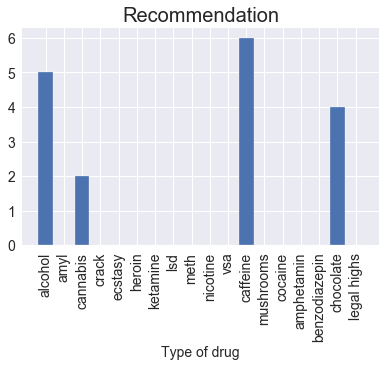

In [376]:

plt.figure(figsize=(6.4,4))
plt.rc('xtick', labelsize=14,)
plt.rc('ytick', labelsize=14,)
plt.bar(range(len(recomm)), recomm.values(), align='center')
plt.xlabel('Type of drug',fontdict={'fontsize':14})
plt.title('Recommendation', fontdict={'fontsize':20})
plt.xticks(range(len(recomm)), list(recomm.keys()),rotation=90)
plt.show()